# BI8040 course - Logical Modeling for Experimental Design in Biotechnology and Biomedicine

## Notebook project of Eirini Tsirvouli & Vasundra Touré

The model of interest in this notebook is the __Mammalian cell cycle__ based on the publication of *Traynard et al.*: [Logical model specification aided by model-checking techniques: application to the mammalian cell cycle regulation](https://doi.org/10.1093/bioinformatics/btw457). 

This project aims to acquire knowledge and a first hands-on on tools for logical modelling and analysis: bioLQM library, GINsim, MaBoSS, Pint and NuSMV.
We show here an attempt to reproduce the results from the paper cited previously and find alternative ways to study the cell cycle model in order to eventually gain new insights. 

The diagram below represent the different nodes' activities during the different phases of the cell cycle. It has been constructed by looking at the rules from the paper and with additional literature curation. Its purpose is only for a better understanding of the cell cycle.

<html>
    <img src="./Cell_cycle.png" width =500>
</html>

### Imports and model loading with GINsim
The first thing to do is to import the necessary tools for performing our analysis.


In [1]:
import ginsim 
import biolqm
import maboss
import pypint
from colomoto_jupyter import tabulate
from colomoto.temporal_logics import *
from itertools import combinations
from functools import reduce

import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas import DataFrame

This notebook has been executed using the docker image `colomoto/colomoto-docker:2018-08-17`

You are using Pint version 2018-07-10 and pypint 1.4.2

Then we load the model using GINsim. In our case, the model is available online with the .zginml format at [http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml](http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml). 

In this project, we have decided to add two output nodes corresponding to two phenotype observed in the model for interpretation purposes: 
* __Proliferation__: when reaching this phenotype, the cell is cycling.
* __Q0_arrest__: when reaching this phenotype, the cell is in the quiescent phase.

This extended model is called *lrg_outputs* in this notebook.

In [2]:
lrg = ginsim.load("http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml")
lrg_outputs = ginsim.load("./model_outputs.zginml")

Downloading 'http://ginsim.org/sites/default/files/Traynard_MultiLevel_MamCC_Apr2016.zginml'

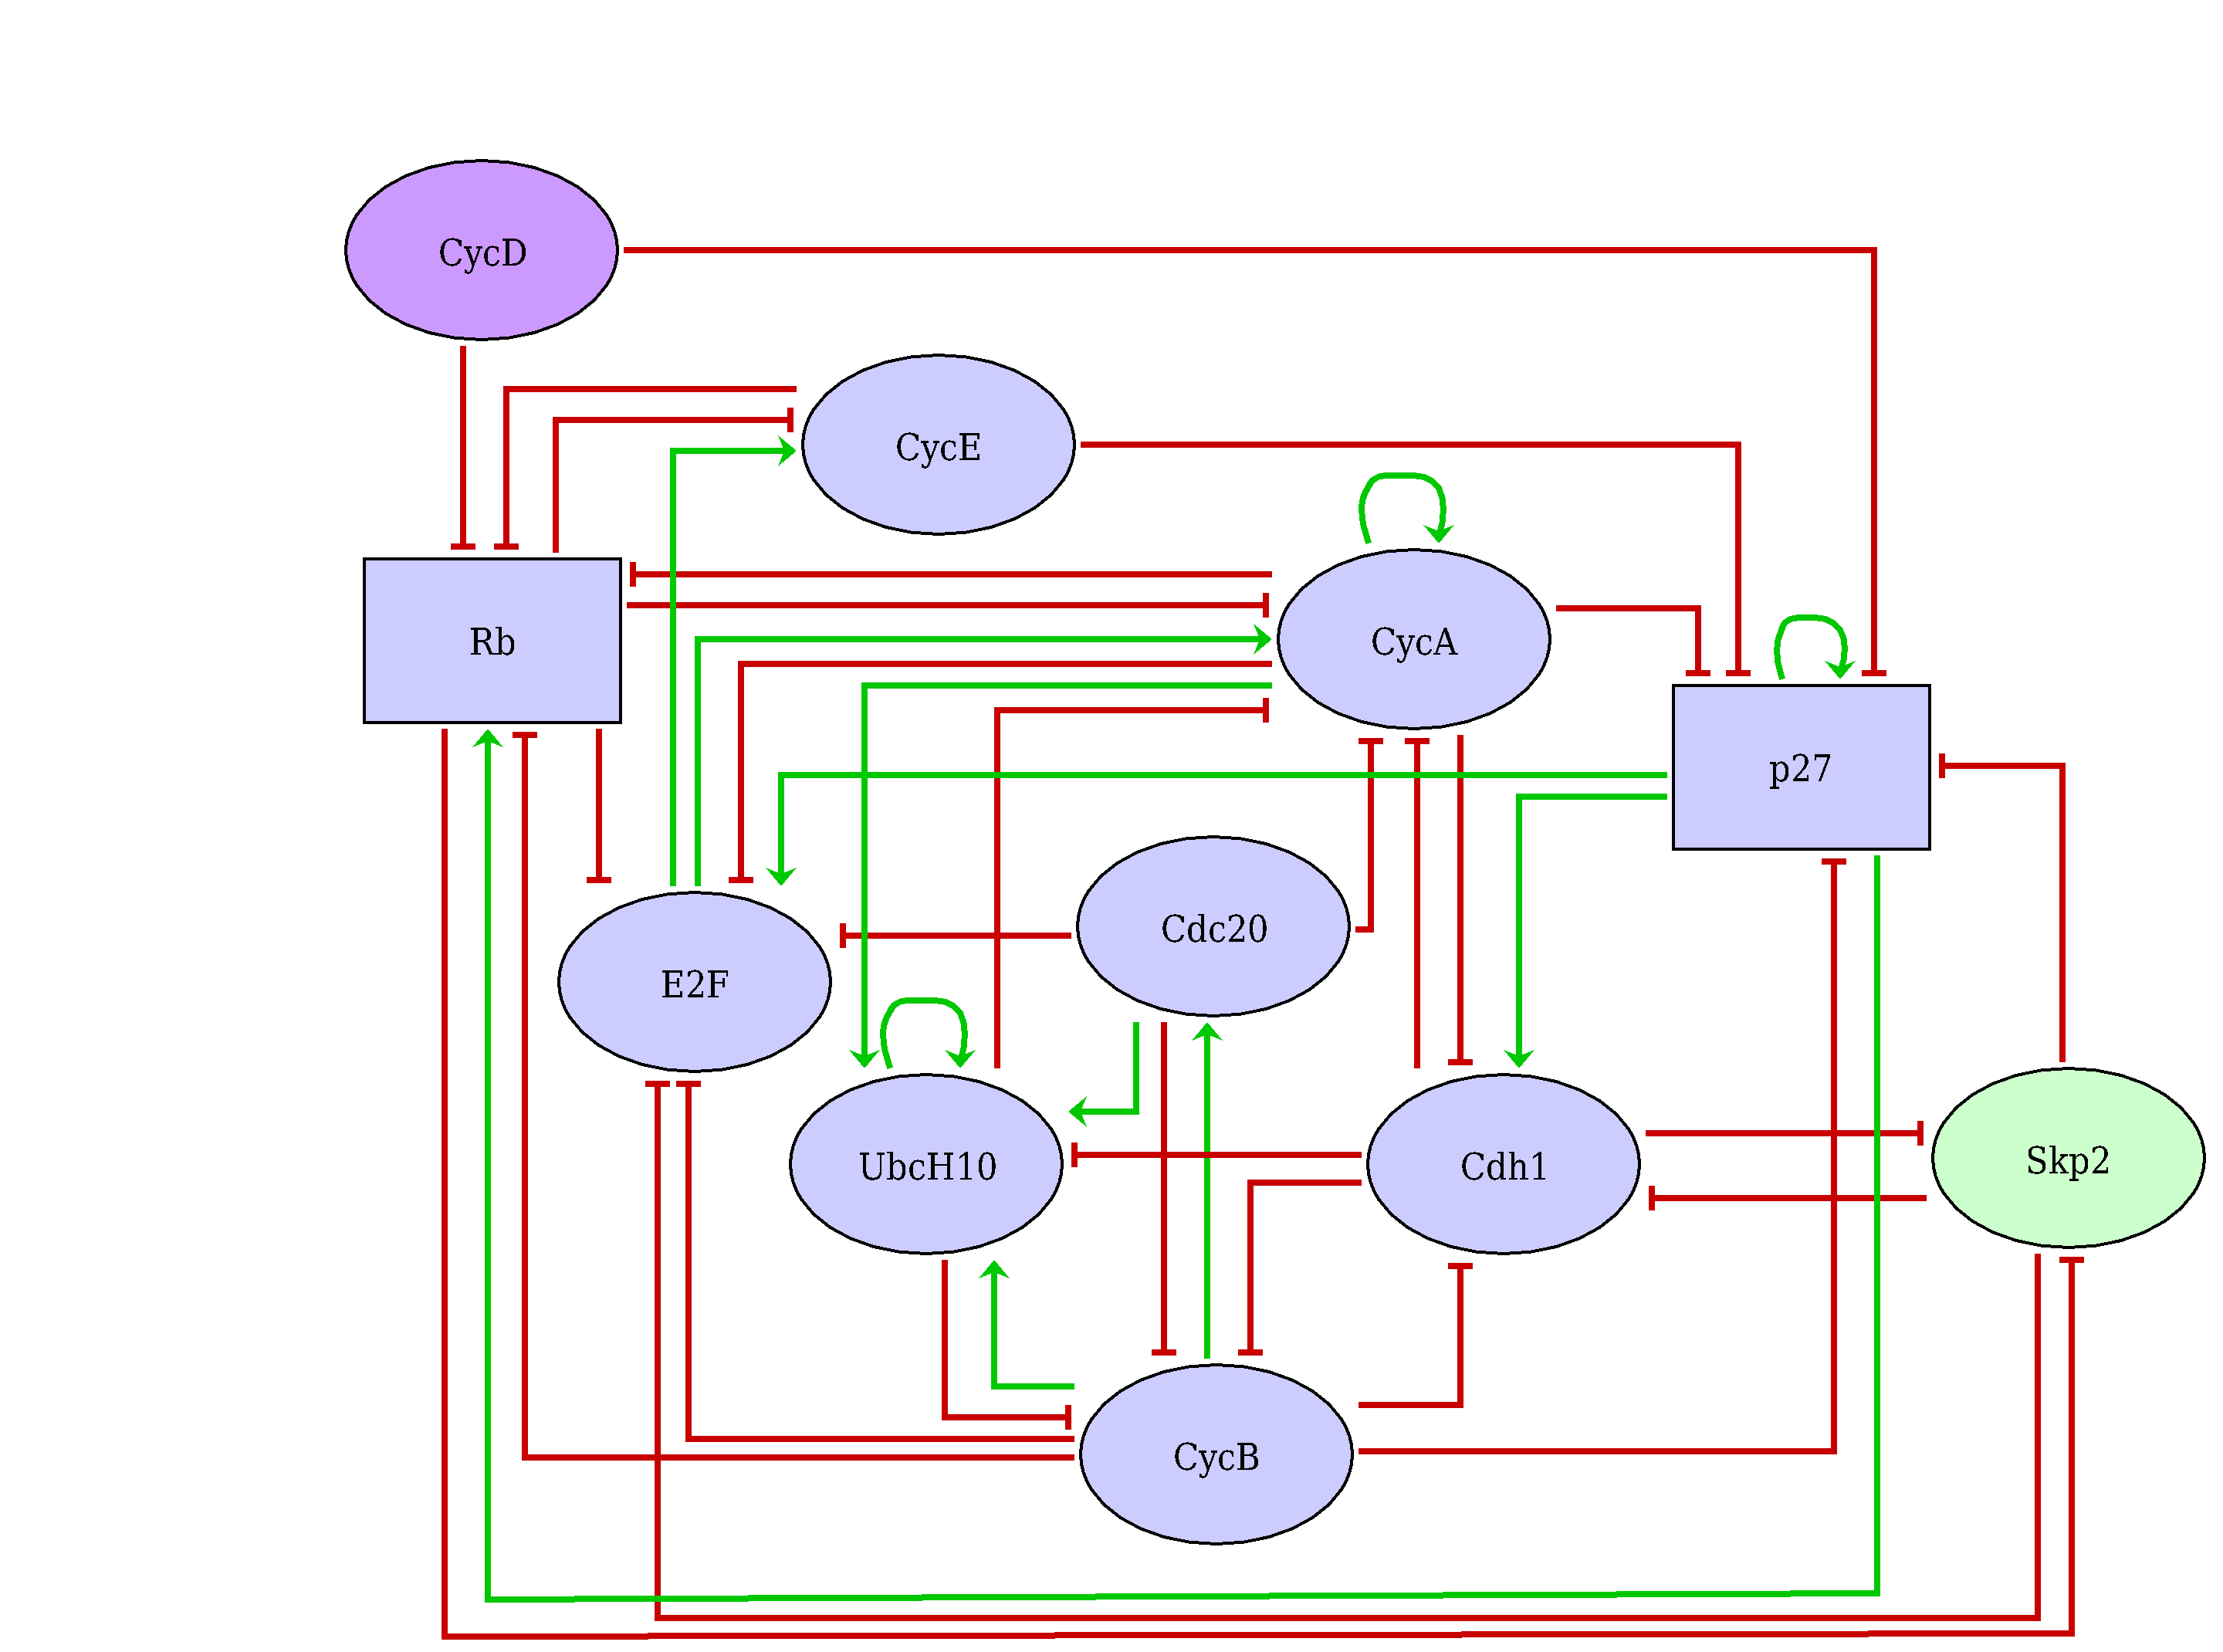

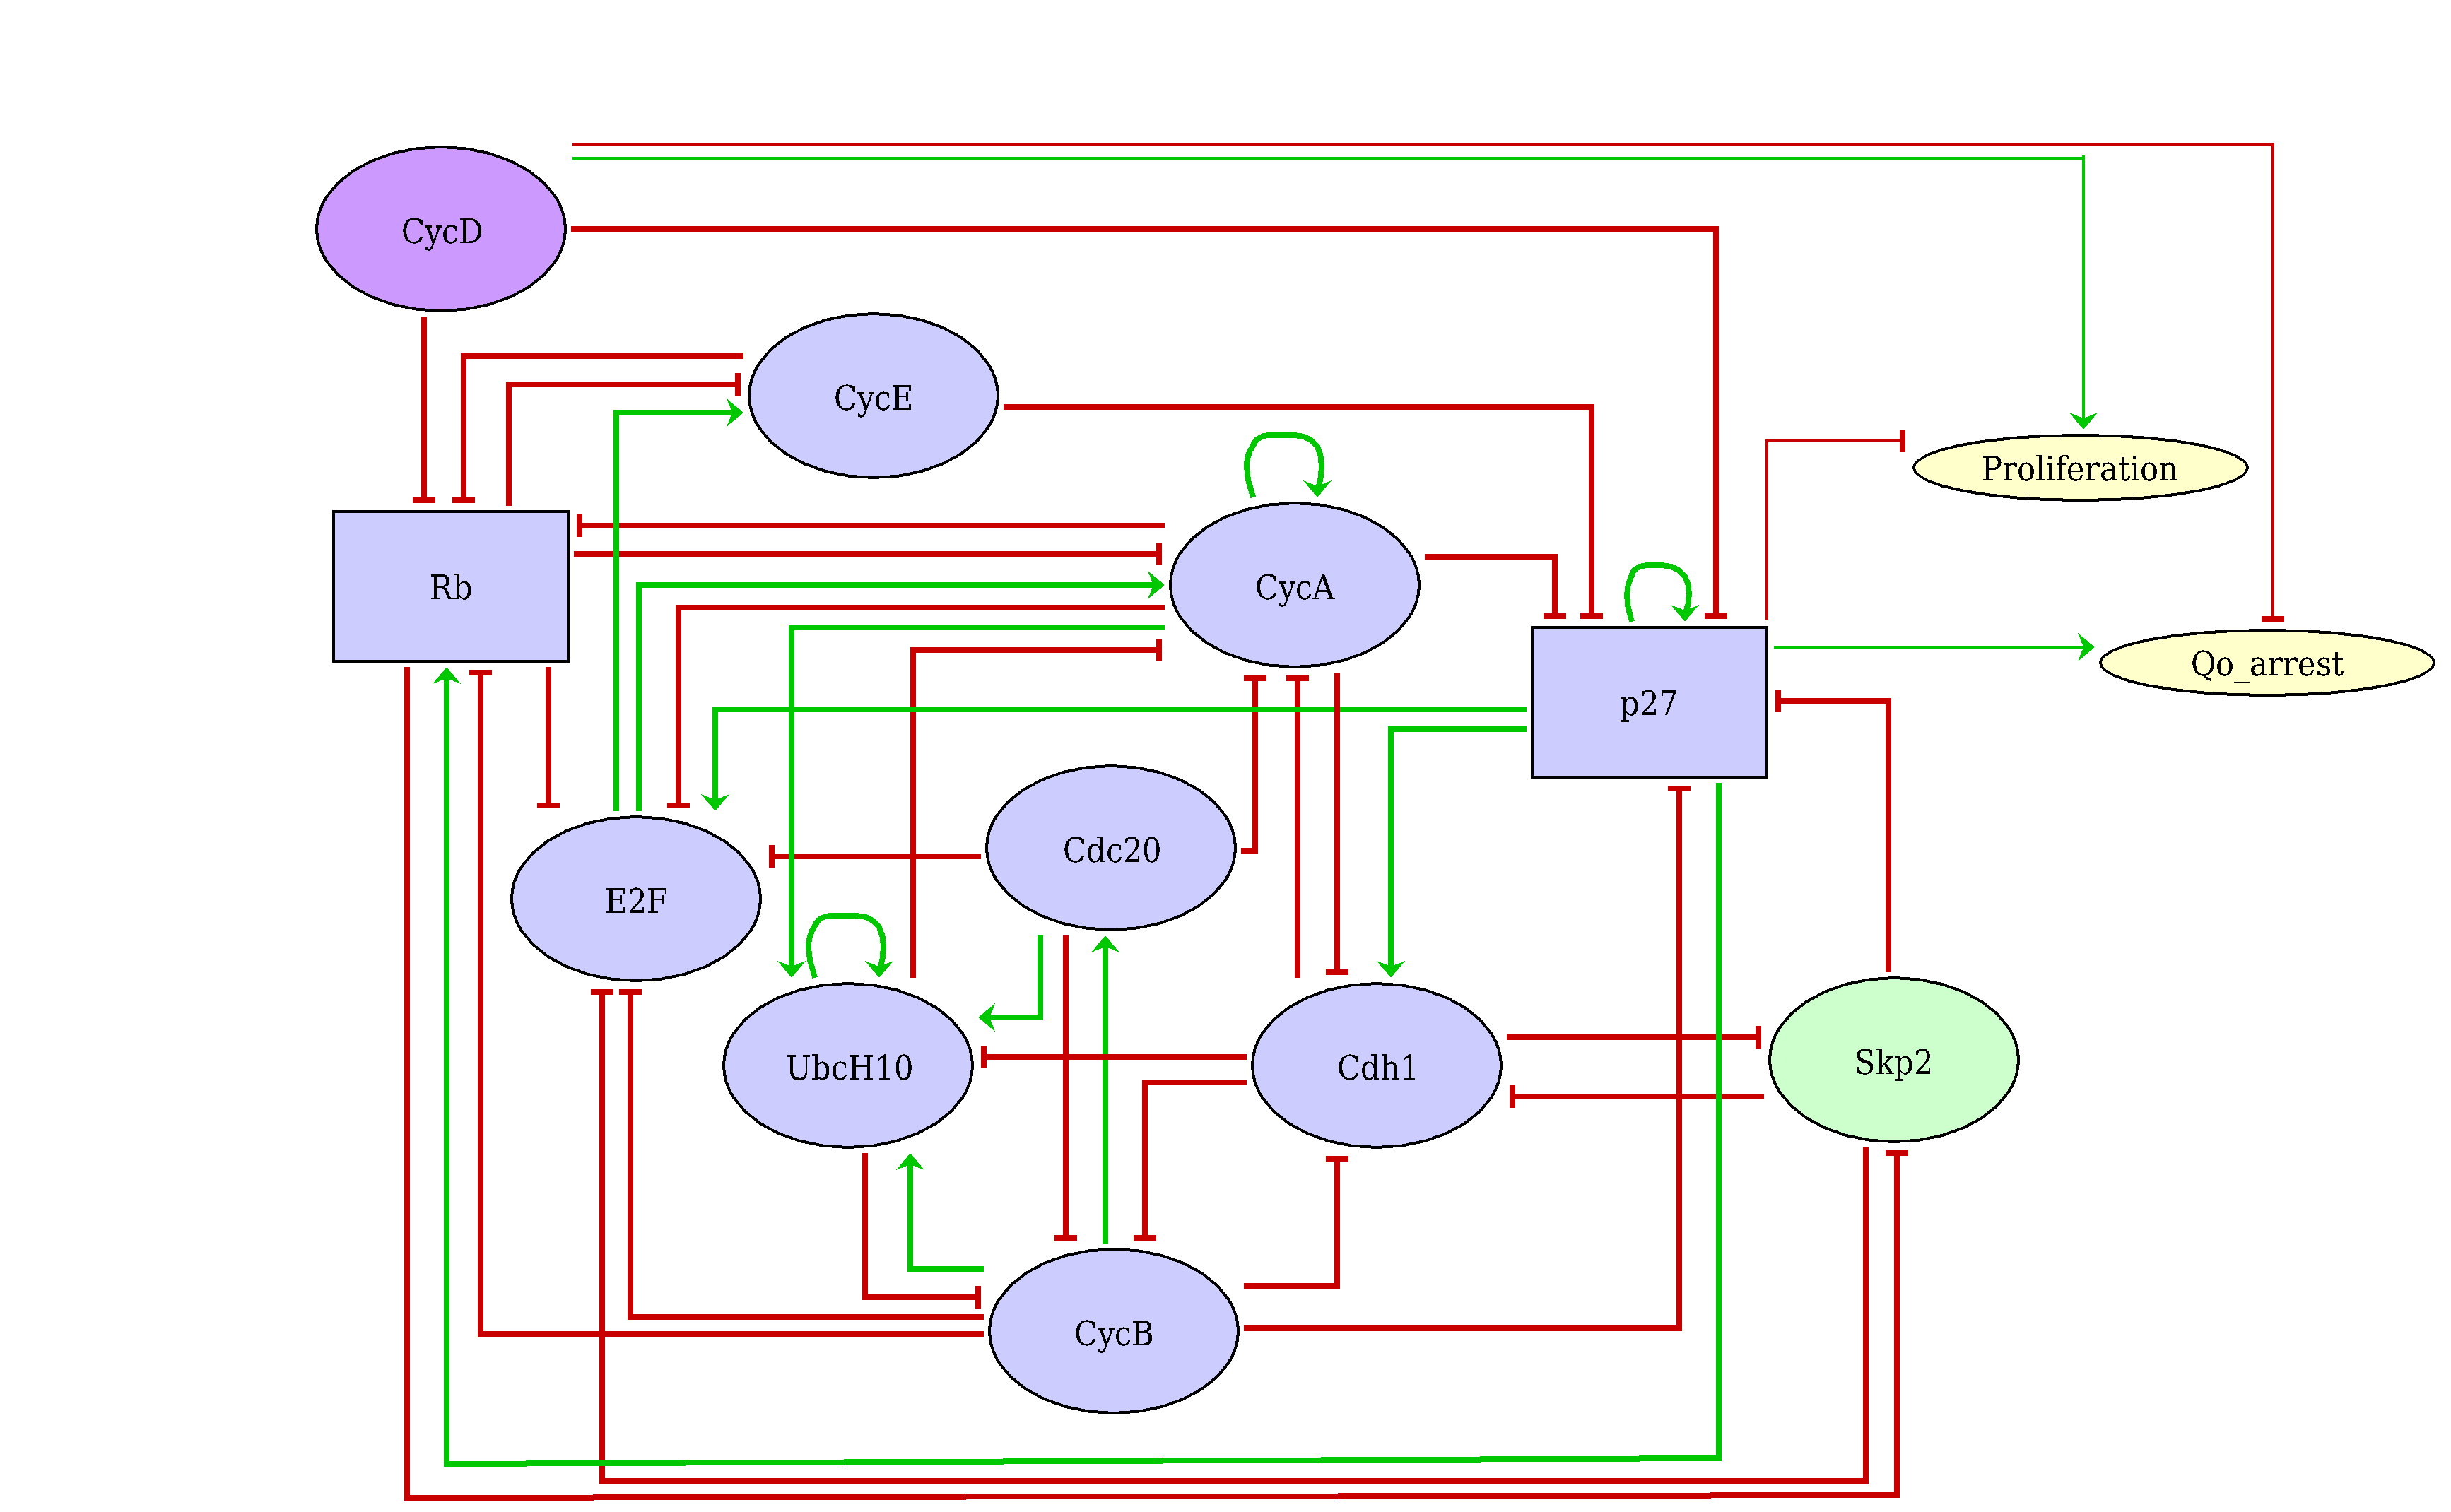

In [3]:
'''Visualisation of the model using a GINsim graph view'''
'''sys.displayhook allows to print multiple calls from a single Jupyter notebook cell - by default, only the last 'print' is shown.'''
sys.displayhook(ginsim.show(lrg))
sys.displayhook(ginsim.show(lrg_outputs))


### Identification of attractors (bioLQM)

The first analysis ran by *Traynard et al.* tries to characterise in their model, the different possible states of the Cell Cycle: the cycle itself and the quiscent state Q0. This is possible by computing the attractors of the model using either GINsim or bioLQM. 
At that time, *Traynard et al.* used GINsim and found 3 attractors: 1 cycle corresponding to the cell cycle, and 2 stable states corresponding to the quiscent state. The existence of these two stable states to represent the quiscent state is a limitation of the model in the level of CycA, mentioned by *Traynard et al.*: the degradation of CycA needs refined rules/regulators in this model. 

Nonetheless, we attempt to reproduce this result by computing first a trap spaces analysis using bioLQM (a library tool to manipulate and analyse logical models, mainly extracted from GINsim). The trap spaces will find attractor states from which the model can not escape from. It can be either a cyclic attractor or a stable state.

#### Trap space analysis to find the attractors of the model

In [4]:
'''Convert ginsim model to a biolqm compliant model '''
lqm = ginsim.to_biolqm(lrg)

In [5]:
'''Compute trap space analysis'''
traps = biolqm.trapspace(lqm)
tabulate(traps)

|    |   CycD |   Rb_b1 |   Rb_b2 |   E2F |   CycE |   CycA |   CycB |   p27_b1 |   p27_b2 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|--------:|--------:|------:|-------:|-------:|-------:|---------:|---------:|--------:|-------:|---------:|-------:|
|  0 |      1 |     255 |       0 |   255 |    255 |    255 |    255 |      255 |        0 |     255 |    255 |      255 |      1 |
|  1 |      0 |       1 |       1 |     0 |      0 |      1 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |
|  2 |      0 |       1 |       1 |     0 |      0 |      0 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |

The trap space analysis gives us 3 attractors: 
* one cyclic attractor in which:
    * the CycD is set to 1, so we are in the cell cycle and not in the quiescent state
    * the inhibitor Rb is not unphosphorylated and the activity of p27 is never set to 2, meaning we are not in the quiescent state
    * the activity of the other cyclins (CycA, CyCb, CycE) oscillates between 0 and 1, confirming again that we are in the cell cycle.
* two stable states where:
    * CycD=0 and the inhibitors are active, meaning we are in the quiscent state
    * the only difference is the activity of CycA, corresponding to the limitation mentionned in the paper.    


In order to double check our results and show an alternative way to compute the attractors, we use the fixpoints function from bioLQM. However, in this case, only stable states can be retrieved. 

We visualise each stable state obtained in a graph that highlights the active components (yellow nodes) and the trajectories (blue arcs) taken with a GINsim function. 

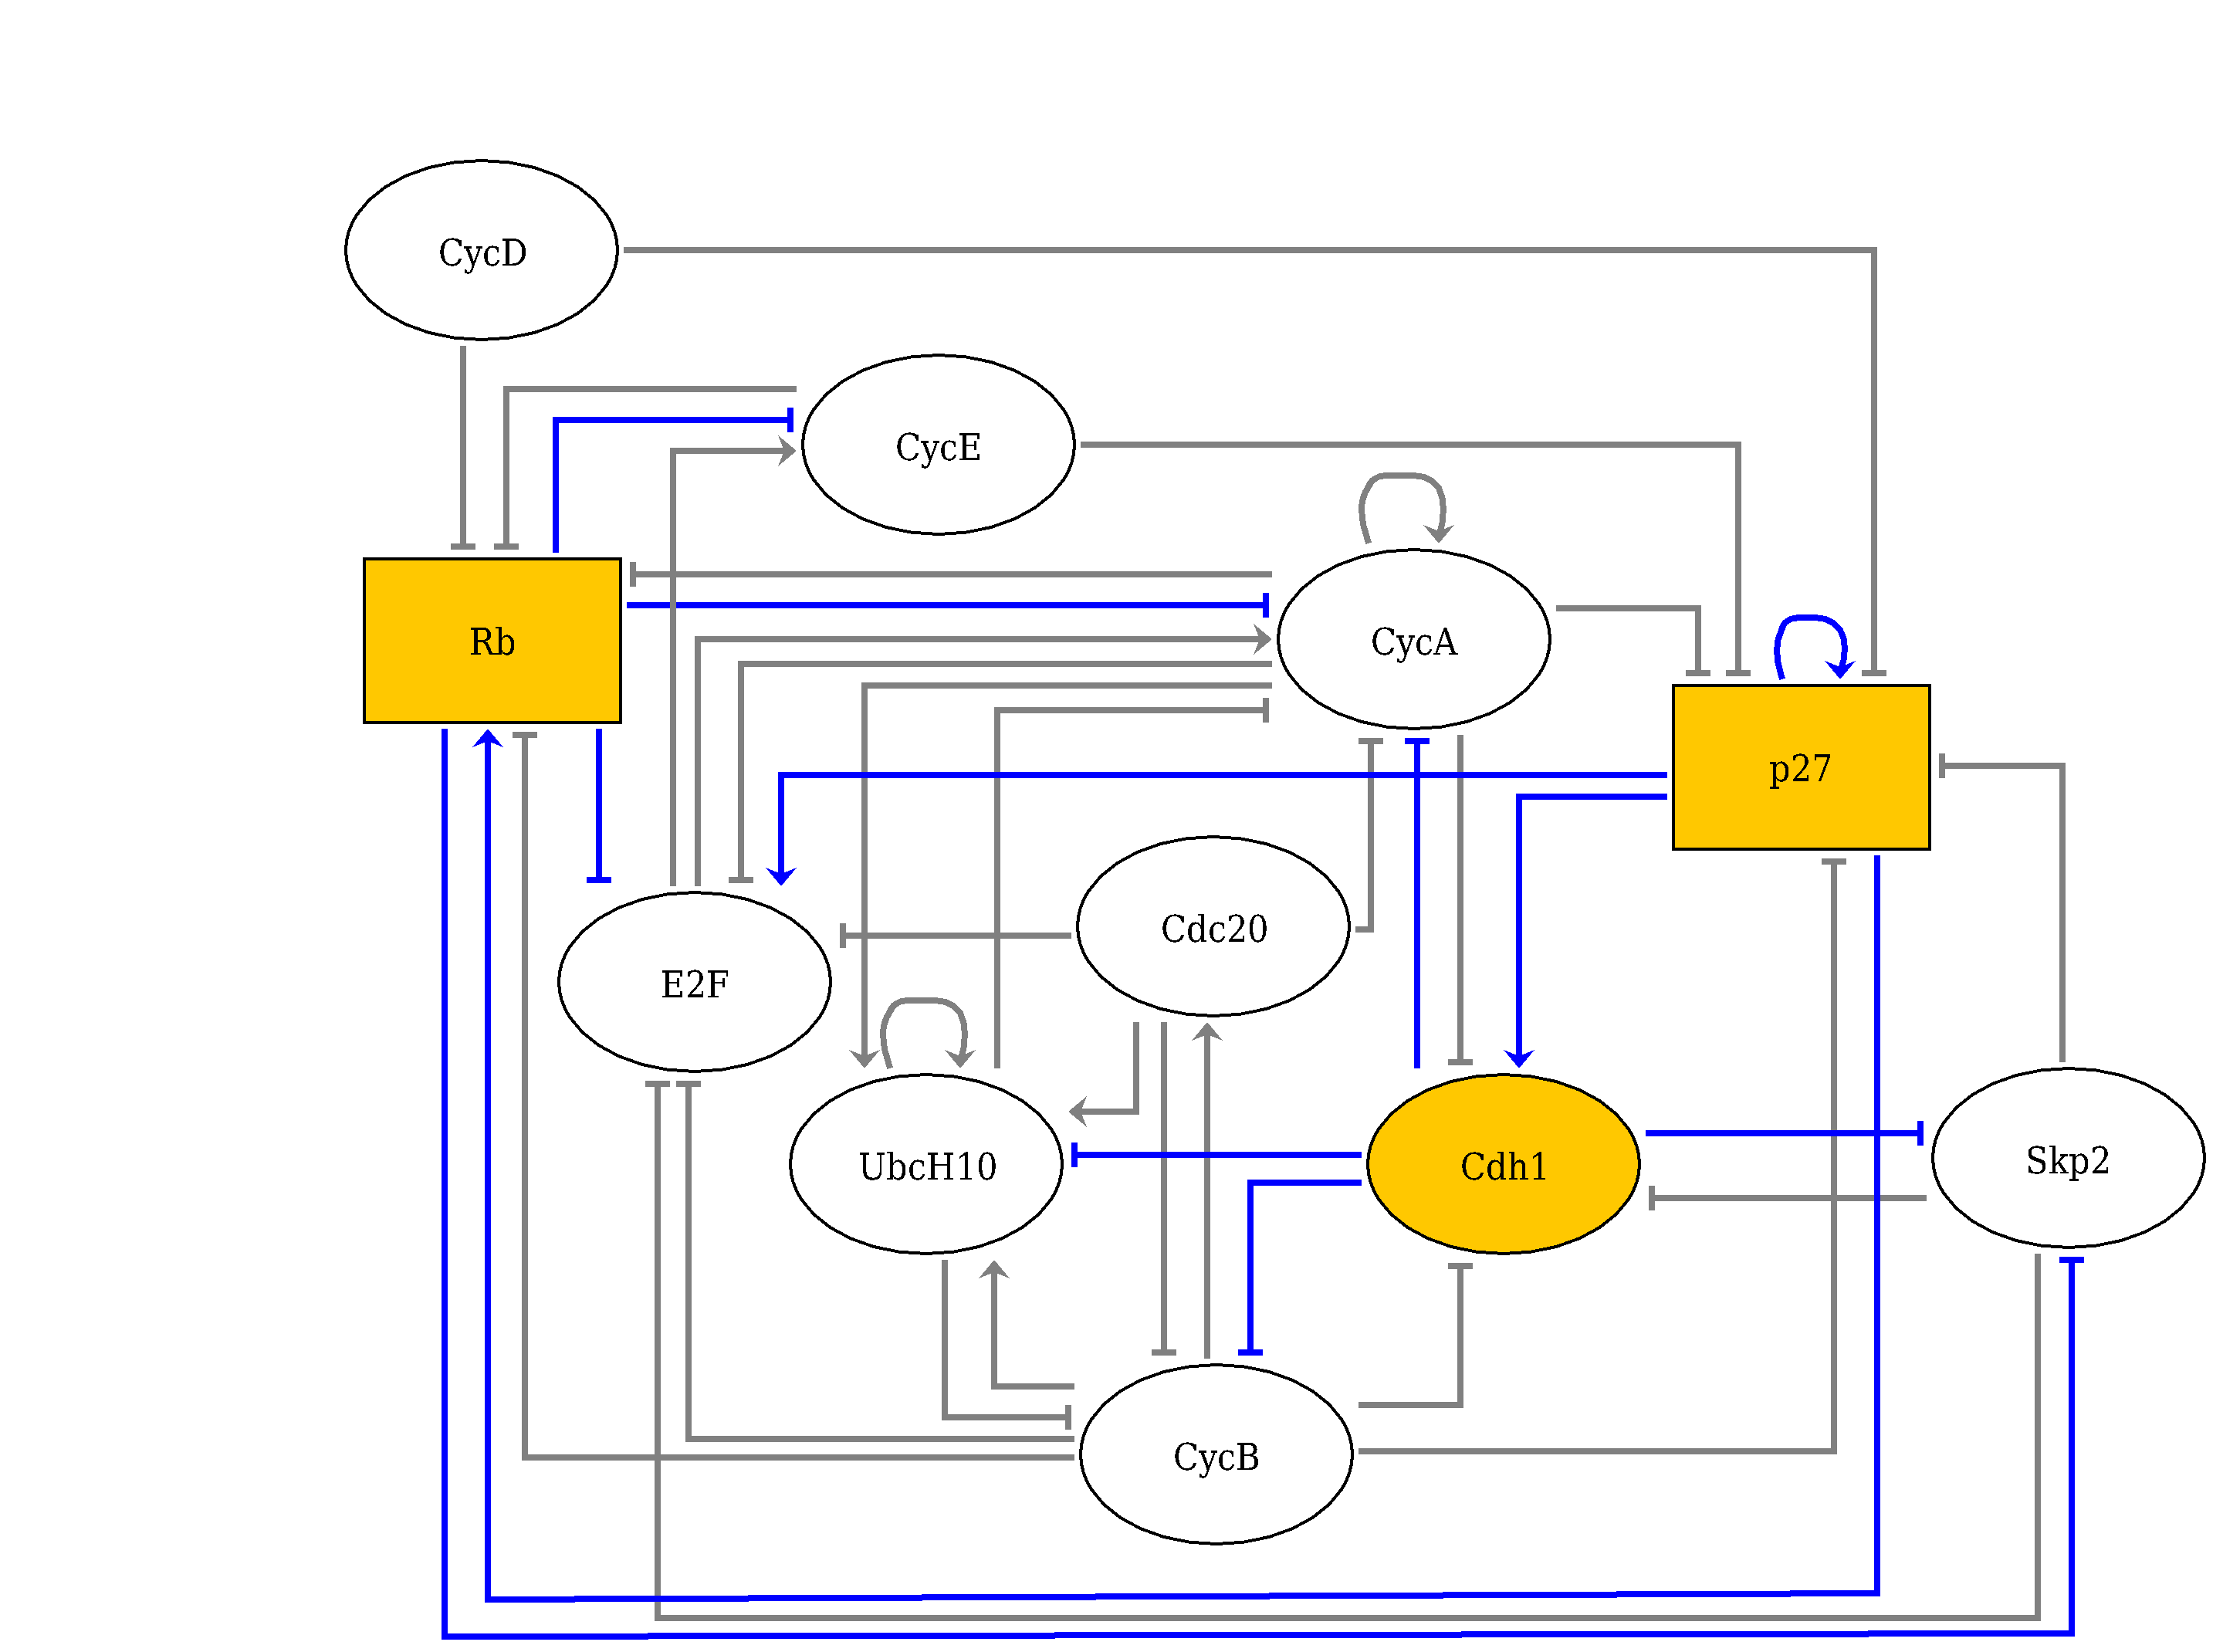

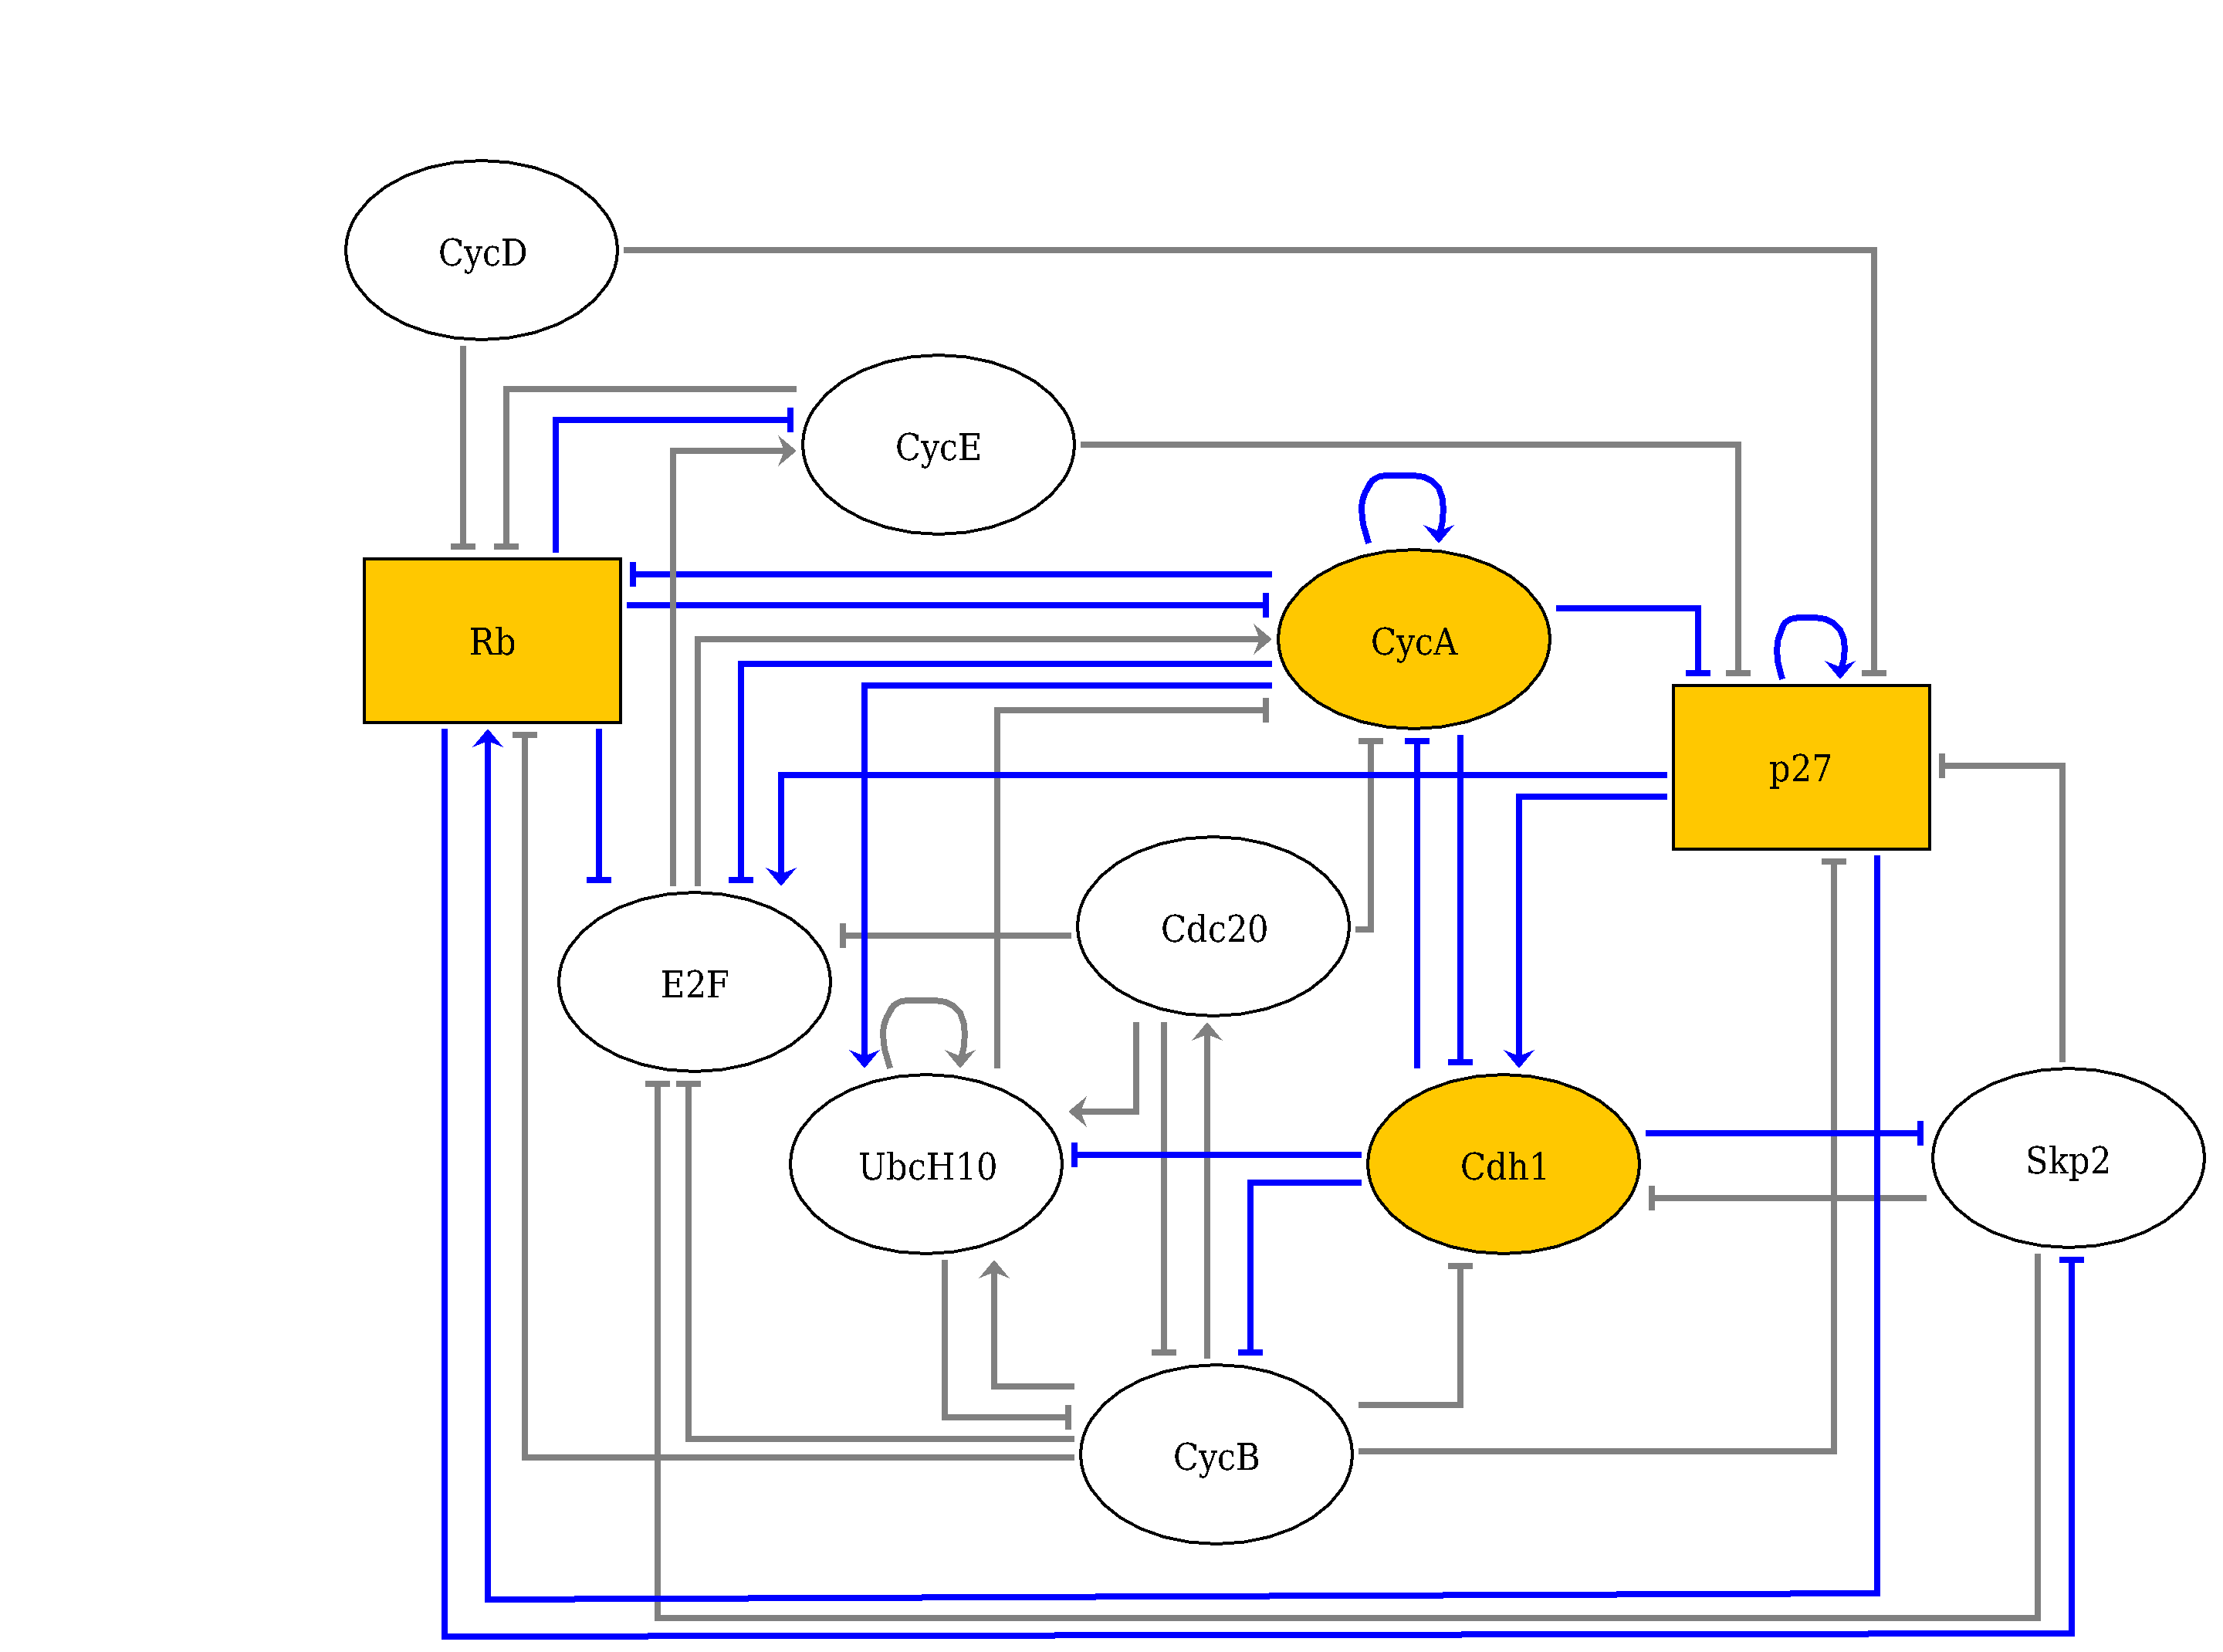

In [6]:
'''Compute stable states'''
fixpoints = biolqm.fixpoints(lqm)
tabulate(fixpoints)

'''Visualisation'''
sys.displayhook((ginsim.show(lrg, fixpoints[0])))
sys.displayhook((ginsim.show(lrg, fixpoints[1])))

As expected, we find the same stable states and can see in the graph that the inhibitors are active (yellow nodes), whereas all other nodes are inactif. So we are in the quiescent state.

With these two analysis, we managed to reproduce and confirm the results found by *Traynard et al.*

You can also visualise the stable state with our modified model (with outputs) *lrg_outputs*. There you directly see that the quiscent state (*Qo_arrest=1*) is active, whereas the cycle is not (*Proliferation=0*):

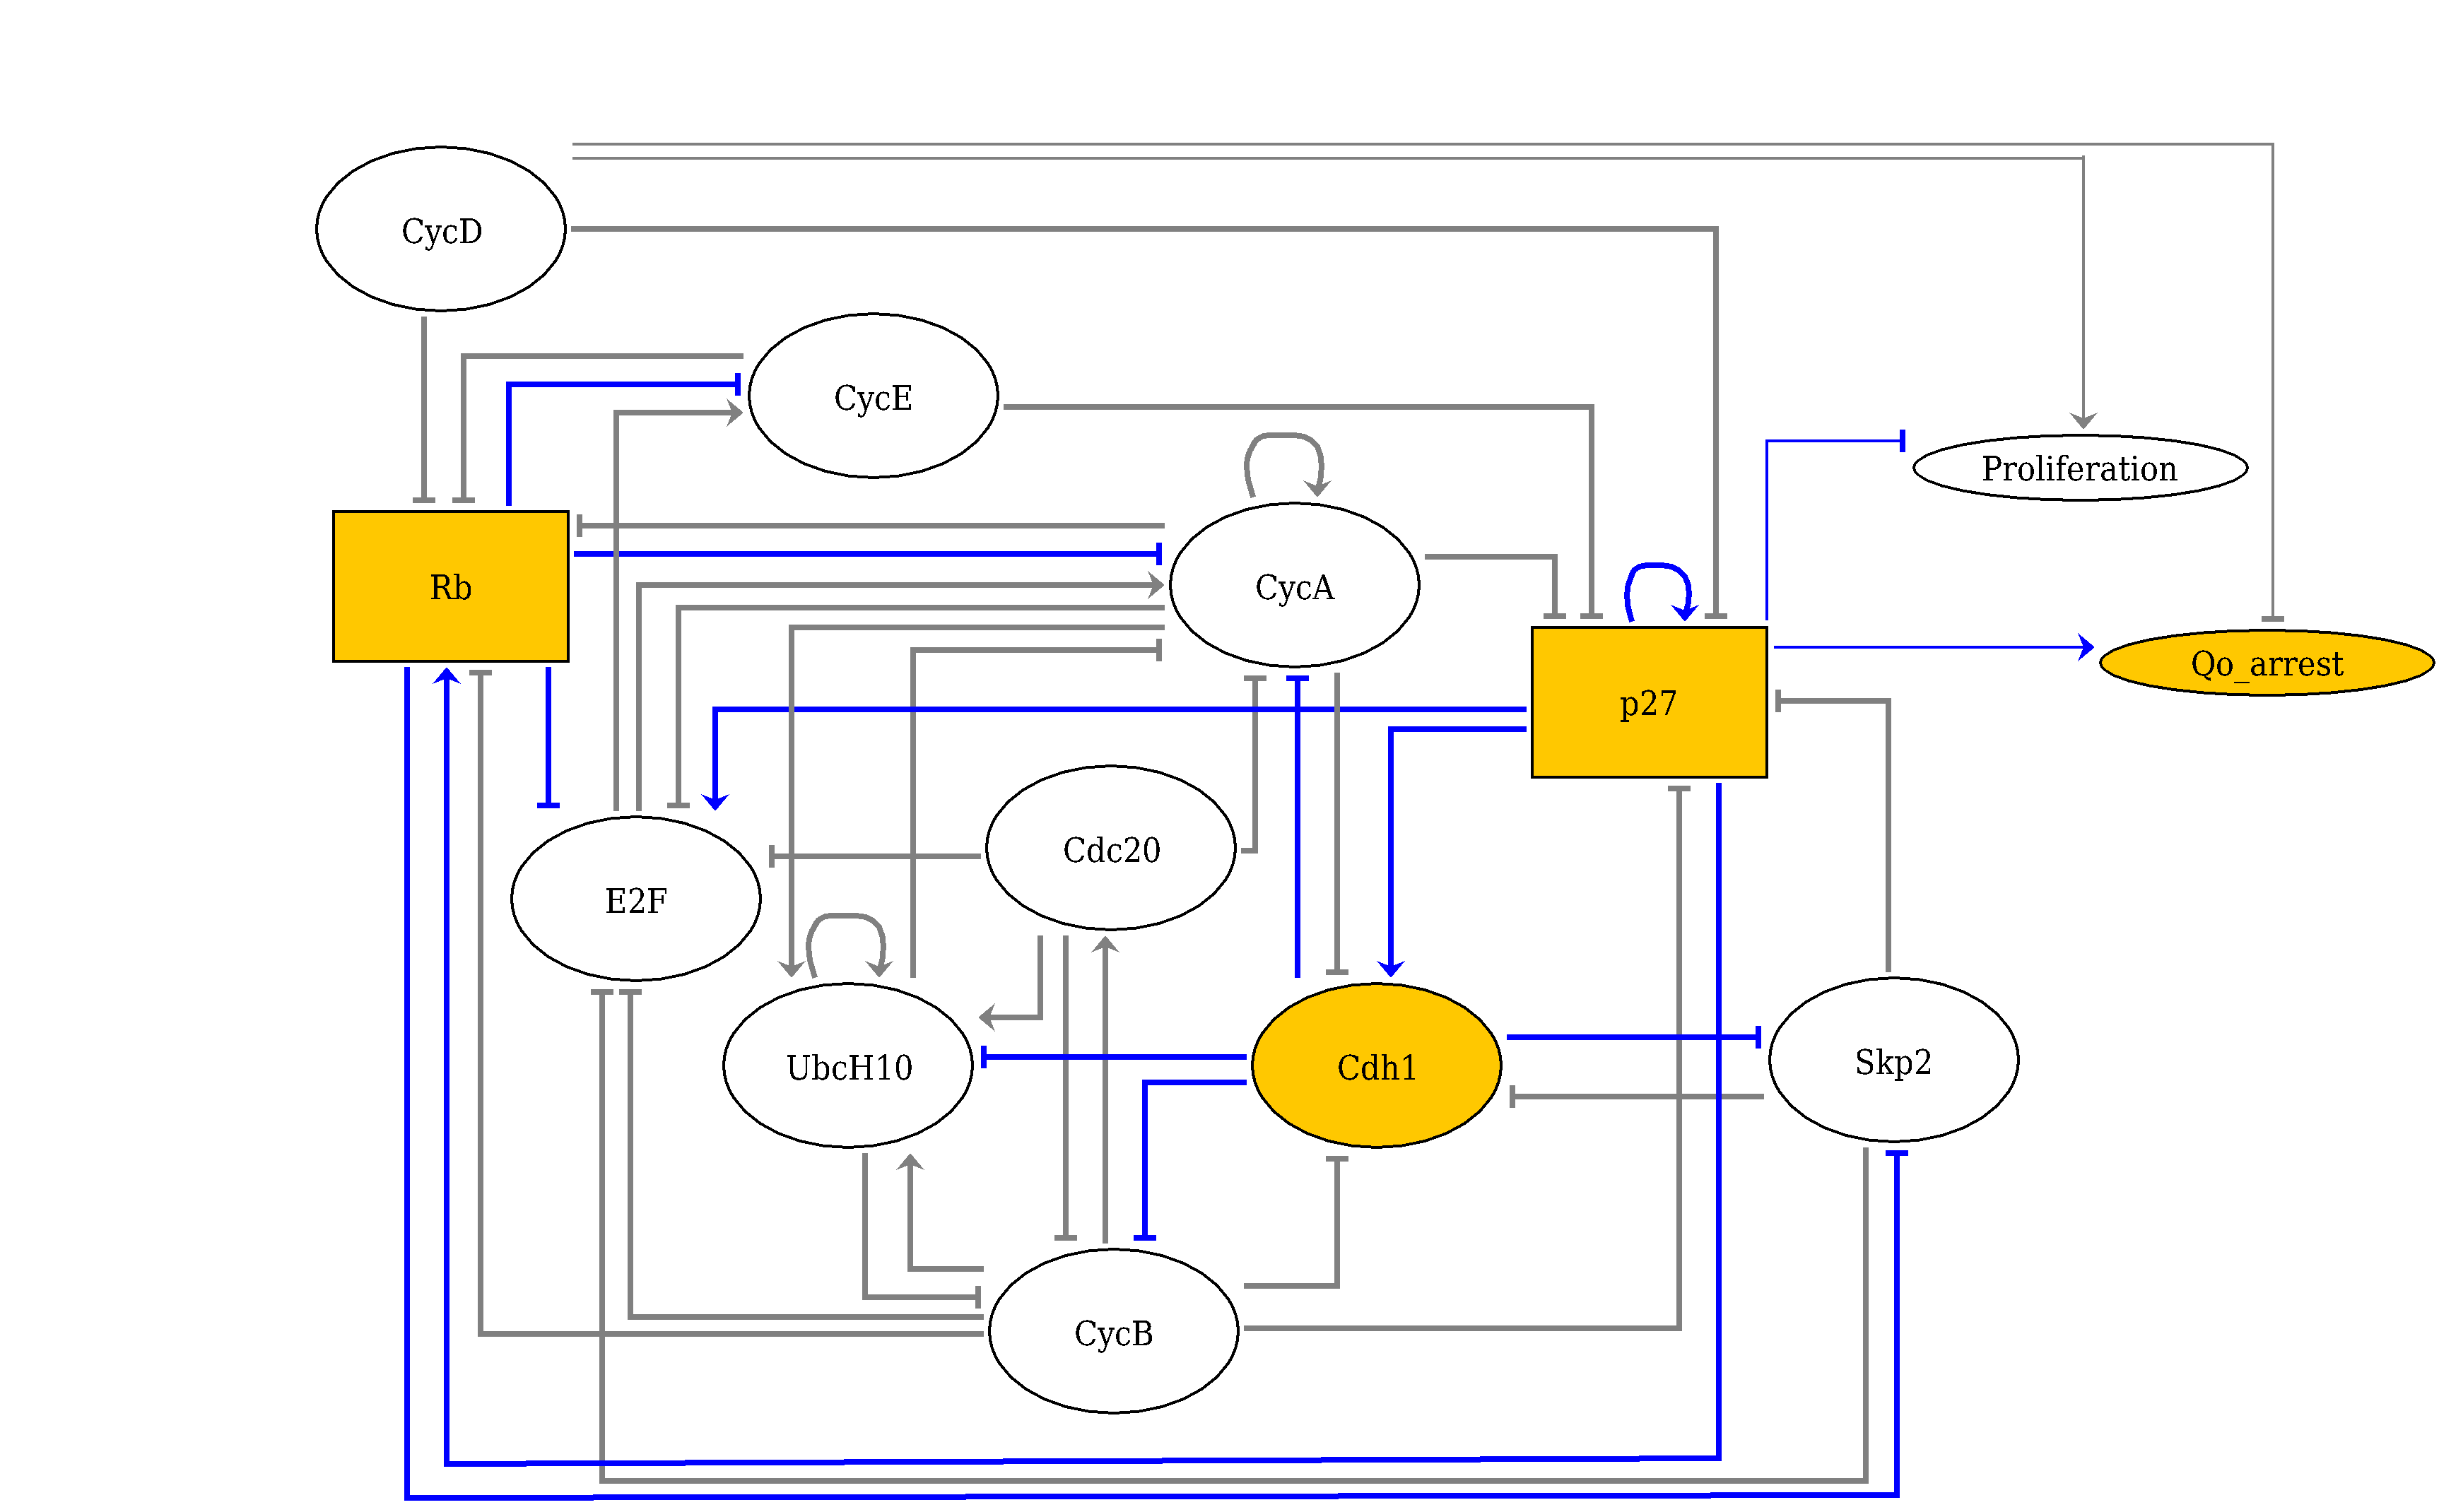

In [7]:
lqm2 = ginsim.to_biolqm(lrg_outputs)
fixpoints = biolqm.fixpoints(lqm2)
sys.displayhook((ginsim.show(lrg_outputs, fixpoints[0])))

### Perturbations analysis

Traynard et al. also analysed 20 experimental mutations (Knock-ins and Knock-outs) to test phenotypes observed in previous publications and to gain insights by comparing the non-mutated states (what we have computed above) and the mutated ones. The mutations are set as perturbations by either having 
* the node permanently ON: *node%1* - ectopic mutation
* the node permanently OFF: *node%0* - knock out mutation
* the effect of a node on another node ON or OFF: *node1:node2%0* - the effect of node2 to node1 is not taken into account in this perturbed model.

To reproduce this, we first apply a perturbation to the model and then try to find the attractors of this perturbed model. The first example below shows how to do one perturbation and compute it's trap space. 
As we have 20 of them to test, we decided to automatise the process by storing the list of perturbations in a python object. We also chose to present the results in a clustered heatmap for better clarity.

#### Single ectopic perturbation example:


In [8]:
ectopic_cyce = biolqm.perturbation(lqm,"CycE%1")
tabulate(biolqm.fixpoints(ectopic_cyce))
tabulate(biolqm.trapspace(ectopic_cyce))

|    |   CycD |   Rb_b1 |   Rb_b2 |   E2F |   CycE |   CycA |   CycB |   p27_b1 |   p27_b2 |   Cdc20 |   Cdh1 |   UbcH10 |   Skp2 |
|---:|-------:|--------:|--------:|------:|-------:|-------:|-------:|---------:|---------:|--------:|-------:|---------:|-------:|
|  0 |      1 |       0 |       0 |   255 |      1 |    255 |    255 |        0 |        0 |     255 |    255 |      255 |      1 |
|  1 |      0 |       0 |       0 |   255 |      1 |    255 |    255 |        0 |        0 |     255 |    255 |      255 |      1 |
|  2 |      0 |       1 |       1 |     0 |      1 |      0 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |
|  3 |      0 |       1 |       1 |     0 |      1 |      1 |      0 |        1 |        1 |       0 |      1 |        0 |      0 |

When knocking in CycE's activity in the model, we observe 4 reachable attractors:
* one cycle where CycD = 1. We are most likely in a cell cycle,
* two stable states where CycD = 0 and we still observe this limitation with CycA. We are most likely in a quiescent state,
* one cycle where CycD = 0. We can question here if the model is cycling in the quiescent state.

#### Automated testing of perturbations:

Given a list of perturbations, written in a understanble way for bioLQM, we create a perturbed model for each perturbation, then compute a fixpoint analysis and store all data under a data frame where the columns represent the nodes of the model and the rows represent the mutations. If no stable state is found, we compute a trap space analysis for these mutations.

In [7]:
'''list of perturbations to test. This list can be modified to test other mutations'''
perturbations = ["CycE%1", 
                 "p27%1", 
                 "p27%1 CycA%1", 
                 "p27%1 CycE%1", 
                 "p27%1 E2F%1",
                 "Rb%2", 
                 "Cdh1%0", 
                 "Rb%0", 
                 "Rb%0 E2F%1", 
                 "E2F%1 Rb%1 CycE:Rb%0 CycA:Rb%0", 
                 "CycE%0",
                 "CycE%0 CycA%0", 
                 "UbcH10%0", 
                 "Rb%1 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "Skp2%0", 
                 "Skp2%0 p27%0", 
                 "Skp2%1 Rb%2 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0", 
                 "Rb%1 p27%0 E2F:Rb%0 CycE:Rb%0 CycA:Rb%0",
                 "p27%0"]

In [8]:
'''Define dictionaries to store attractors for each perturbation'''
fixpointlist = {}

'''trapspacelist is used for perturbations where no stable state is found
    to find eventual cyclic attractors.'''
trapspacelist = {}

for p in perturbations:
    fixpoints = biolqm.fixpoints(biolqm.perturbation(lqm, p))
    if(fixpoints):
        fixpointlist[p] = fixpoints
    else:
        '''No stable state found, so we look for cycles'''
        trapspace = biolqm.trapspace(biolqm.perturbation(lqm, p))
        trapspacelist[p] = trapspace

'''uncomment to see attractors in tabulated tables for each perturbation
for k, v in fixpointlist.items():
    print(k)
    sys.displayhook(tabulate(v))
    print()
    
for k, v in trapspacelist.items():
    print(k)
    sys.displayhook(tabulate(v))
    print()'''

'uncomment to see attractors in tabulated tables for each perturbation\nfor k, v in fixpointlist.items():\n    print(k)\n    sys.displayhook(tabulate(v))\n    print()\n    \nfor k, v in trapspacelist.items():\n    print(k)\n    sys.displayhook(tabulate(v))\n    print()'

Text(0.5,0.98,'Clustered heatmap of each stable states found for each perturbation')

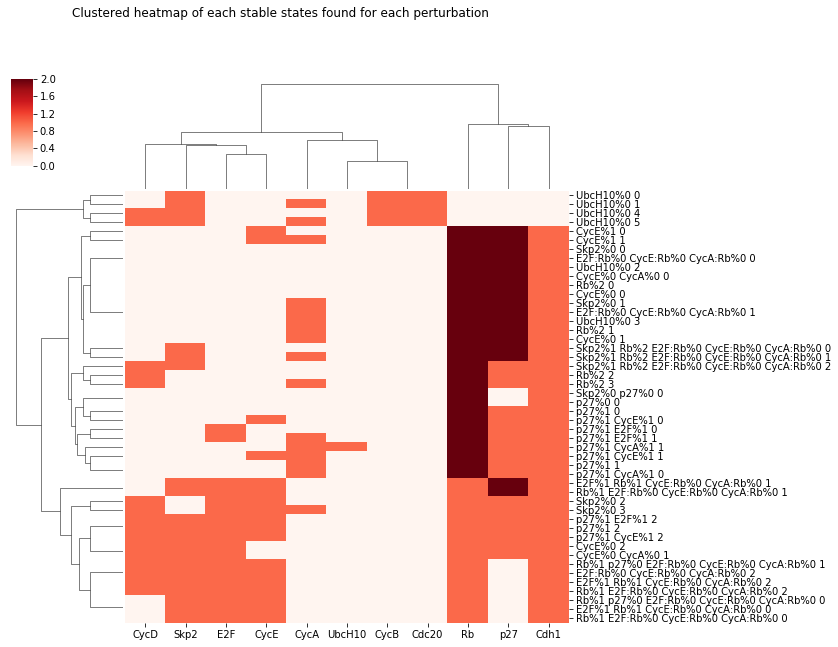

In [9]:
import seaborn as sns

'''List of perturbations with the nb of stable states '''
perturbstates=[]
trappedstates=[]

'''List of table state values same order as perturbStates'''
stablestates = [] 
tstates = [] 

'''List of nodes'''
nodelist = ['CycD', 'Rb', 'E2F', 'CycE', 'CycA', 'CycB', 'p27', 'Cdc20', 'Cdh1', 'UbcH10', 'Skp2']

for k,v in fixpointlist.items():   
    for i in range(0,len(v)):
        listSS = []
        for key, val in v[i].items():
            listSS.append(val)
        stablestates.append(listSS)
        perturbstates.append(str(k)+' '+str(i))

'''Create dataframe: columns = nodes, rows = perturbations'''
df = DataFrame(data=stablestates)
df.columns = nodelist
df.index = perturbstates

'''Generate clustered heatmap'''
cm = sns.clustermap(df, metric='euclidean', cmap = 'Reds', yticklabels=True)
cm.fig.suptitle('Clustered heatmap of each stable states found for each perturbation')

Each row of this heatmap represents a mutation (or perturbed model) and each column is a node from the model. The white color corresponds to the value 0, the orange color correspond to the value 1 and the color red corresponds to the value 2 of the node. The data has been clustered according to a Euclidean distance.

First, looking at the clustering of the nodes, we observe that the inhibitors (Rb, p27, Cdh1) are clustered together. This is expected as we know that their activities are coordinated accross different cell cycle phases (including the quiescent state). At the same time, due to the high specificity of the time and order of the activation of the entities during the cell cycle, we notice that the different possible clusters correspond to specific cell cycle phases (e.g, CycD, Skp2, E2F, CycE are clustered together and can correspond to the G1 phase).

The results are consistent with *Traynard et al*: we are able to find the phenotypes predicted in the heatmap.
To further analyse the results, we can see that we do not see a specific trend in the observations:
* the clusters are very small meaning that a few perturbations are similar
* for most of the mutations, we observe both of possible outcomes (cell cycle arrest or quiescent state)
* for most of the perturbations, we seem to be able to reach the quiescent state as CycD is OFF.

Text(0.5,0.98,'Clustered heatmap of each cyclic attractors found for perturbations not leading to a stable state')

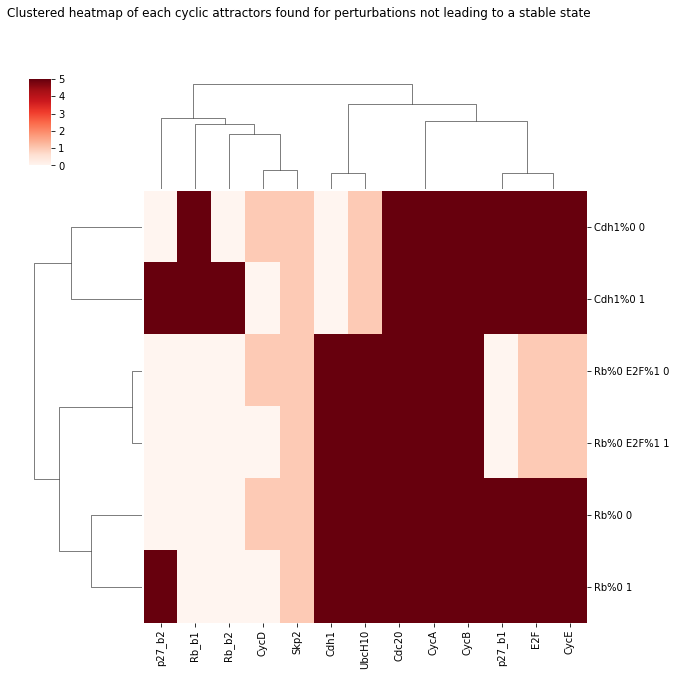

In [10]:
'''Repeat previous analysis for the trap space data'''
for k,v in trapspacelist.items():   
    for i in range(0,len(v)):
        listSS = []
        for key, val in v[i].items():
            if val == 255:
                val = 5
            listSS.append(val)
        tstates.append(listSS)
        trappedstates.append(str(k)+' '+str(i))

'''List of nodes in the trap space: multi valued components are expanded into several nodes'''        
nodelistT = ['CycD', 'Rb_b1', 'Rb_b2', 'E2F', 'CycE', 'CycA', 'CycB', 'p27_b1', 'p27_b2', 'Cdc20', 'Cdh1', 'UbcH10', 'Skp2']

df2 = DataFrame(data=tstates)
df2.columns = nodelistT
df2.index = trappedstates
cm2 = sns.clustermap(df2, metric='euclidean', cmap = 'Reds', yticklabels=True)
cm2.fig.suptitle('Clustered heatmap of each cyclic attractors found for perturbations not leading to a stable state')


Similarly to the first heatmap, each row represents a mutation and each column a node from the model.
For unfixed node states (nodes oscillating between 0 and 1), bioLQM set their value to 255. Thus, for readability reasons of the heatmap, we decided to change this value to 5 to have a low range of gradient values. This way, we are able to distinguish clearly when the nodes are ON or OFF (value 1 with saumon color, or 0 with white color) and when the nodes are oscillating (value 5, red color). 

Moreover, multivalued entities are split into two nodes when calculating trap spaces. For this reason, extra attention should be paid on their interpretation. For example, when Rb_b2 is ON ("pink" color), we know that Rb's value is equal to 2, while when Rb_b2 is OFF (white color), we are certain that Rb's value is NOT equal to 2 and can either be 1 or 0. In order to define it, we have to look at the value of Rb_b1.

As seen from this second heatmap and as commented in *Traynard et al.* the mutations lead to a viable cell cycle as we observe complex attractors with the cyclins and the inhibitors oscillating.

### Testing stable state reachability from a mutated initial state (Pint, MaBoSS)

In the previous analysis we got all the possible stable states for each mutated model but it doesn't mean that we are able to reach them given some initial conditions. The question now is: are we able to reach the quiescent state starting from a perturbated initial state and CycD OFF? 

To answer this question, we use the software Pint. Due to the limitations of the software when it comes to querying the initial states, we are not able to include perturbations where the regulatory effect over a node is not taken into account.

In [9]:
perturbations = ["CycE%1", 
                 "p27%1",                 
                 "p27%1 CycA%1", 
                 "p27%1 CycE%1", 
                 "p27%1 E2F%1",
                 "Rb%2", 
                 "Cdh1%0", 
                 "Rb%0", 
                 "Rb%0 E2F%1", 
                 "CycE%0",
                 "CycE%0 CycA%0", 
                 "UbcH10%0", 
                 "Skp2%0", 
                 "Skp2%0 p27%0",
                 "p27%0"]

for perturb in perturbations:
    lock_dict = {}
    py_model = biolqm.to_pint(lqm)
    for mutation in perturb.split():
        '''Pint settings'''
        py_model.initial_state[mutation.split('%')[0]] = int(mutation.split("%")[1])
        lock_dict[mutation.split('%')[0]] = int(mutation.split("%")[1])

    print(display(tabulate(py_model.lock(lock_dict).reachable_attractors())))
    print(lock_dict, "reaches quiescent state: \t", py_model.lock(lock_dict).reachability("CycD=0"))

    print()

|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | cyclic   |     30 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 1, 'p27': 0, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | cyclic   |      4 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 1, 'Skp2': 0} |

None
{'p27': 1, 'CycA': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1, 'CycE': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 1, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 1, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 1, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 1, 'E2F': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Rb': 2} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |    288 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 1, 'Skp2': 1} |

None
{'Cdh1': 0} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |    296 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 1} |

None
{'Rb': 0} reaches quiescent state: 	 True



|    | type   |   size | sample                                                                                                                   |
|---:|:-------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | cyclic |     15 | {'CycD': 0, 'Rb': 0, 'E2F': 1, 'CycE': 1, 'CycA': 1, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |

None
{'Rb': 0, 'E2F': 1} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'CycE': 0, 'CycA': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 1, 'p27': 0, 'Cdc20': 1, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |
|  2 | fixpoint |      1 | {'CycD': 0, 'Rb': 0, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 1, 'p27': 0, 'Cdc20': 1, 'Cdh1': 0, 'UbcH10': 0, 'Skp2': 1} |
|  3 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'UbcH10': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |
|  1 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 1, 'CycB': 0, 'p27': 2, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Skp2': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'Skp2': 0, 'p27': 0} reaches quiescent state: 	 True



|    | type     |   size | sample                                                                                                                   |
|---:|:---------|-------:|:-------------------------------------------------------------------------------------------------------------------------|
|  0 | fixpoint |      1 | {'CycD': 0, 'Rb': 2, 'E2F': 0, 'CycE': 0, 'CycA': 0, 'CycB': 0, 'p27': 0, 'Cdc20': 0, 'Cdh1': 1, 'UbcH10': 0, 'Skp2': 0} |

None
{'p27': 0} reaches quiescent state: 	 True



As seen from the above results, we are able to reach the quiscent state for all the tested pertubations. 
Worth mentioning is that although all of the results were in agreement with *Traynard et. al* paper we observed an additional information: The mutation with CycA and p27 equal to 1 show that we reach a cyclic attractor inside the quiscent state. For this specific mutation we calculate the probability of reaching this attractor using MaBoSS.

In [10]:
mab_model = ginsim.to_maboss(lrg)
mab_model.mutate('CycA', 'ON')
mab_model.mutate('p27_b1', 'ON')
mab_model.mutate('p27_b2', 'OFF')

In [11]:
mut_results = mab_model.run()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: DtypeWarning: Columns (23,26,29,32,35,38,41,44,47,50,53,56,59,62,65,68,71,74,77,80,83,86,89,92,95,98,101,104,107,110,113,116,119,122,125,128,131,134,137,140,143,146,149,152,155,158,161,164,167,170,173,176,179,182,185,188,191,194,197,200,203,206,209,212,215,218,221,224,227,230,233,236,239,242,245,248,251,254,257,260,263,266,269,272,275,278,281,284,287,290,293,296,299,302,305,308,311,314,317,320,323,326,329,332,335,338,341,344,347,350,353,356,359,362,365,368,371,374,377,380,383,386,389,392,395,398,401,404,407,410,413,416,419,422,425,428,431,434,437,440,443,446,449,452,455,458,461,464,467,470,473,476,479,482,485,488,491,494,497,500,503,506,509,512,515,518,521,524,527,530,533,536,539,542,545,548,551,554,557,560,563,566,569,572,575,578,581,584,587,590,593,596,599,602,605,608,611,614,617,620,623,626,629,632,635,638,641,644,647,650,653,656,659,662,665,668,671,674,677,680,683,686,689,692,695,698,701,704,707,710,713,7

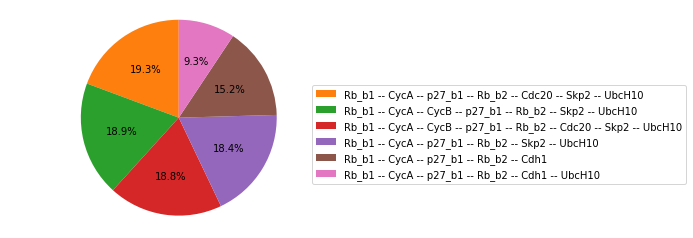

In [12]:
mut_results.plot_piechart()

The piechart shows that the cyclic attractor has the lowest probability (9.1%) to be reached compared to the other reachable states.

### Finding mutations that prevent the quiscent state (PINT, MABOSS)

As all of the mutations were able to reach the quiscent state, we now want to look for mutations that actually prevent reaching it. For that reason, we combine Pint and MaBoSS to first identify these mutations and then compute the probabilities of reaching the possible states.

Initially we perform a wild type simulation to calculate the probabilities of the reachable states, starting from a state where CycD is equally probable to be active or inactive. 

In [13]:
wt_sim = biolqm.to_maboss(lqm)

In [14]:
wt_sim.network.set_istate("CycD", [0.5,0.5])

In [15]:
wt_sim.update_parameters(max_time=50)

In [16]:
wt_res = wt_sim.run()

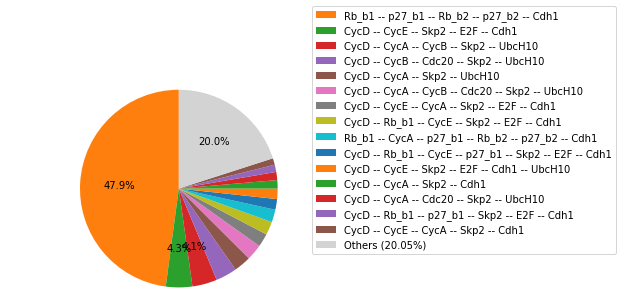

In [17]:
wt_res.plot_piechart()

As expected, ~50% of the time we reach the quiscent state where CycD is OFF and the rest of the time we are in the cell cycle.

Then we plot the nodes' trajectories across time. We can clearly see the sequential activation of the cyclins and the inhibitors. After a specific time point, the values are stabilized because of the desynchronization of the cells.

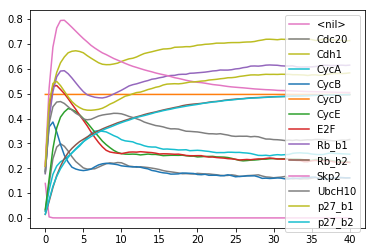

In [18]:
wt_res.plot_node_trajectory(until=40)

Afterwards, we use Pint and starting from the quiscent state (CycD = 0), we identify the mutations that force the model to leave the quiscent state.

In [19]:
m = biolqm.to_pint(lqm)

In [20]:
m.initial_state["CycD"] = 0

In [21]:
mutants = m.oneshot_mutations_for_cut("Rb=2, p27=1, Cdh1=1")
mutants

This computation is an *under-approximation*: returned mutations are all valid, but they may be non-minimal, and some solutions may be missed.

Limiting solutions to mutations of at most 5 automata. Use `maxsize` argument to change.

[{'CycD': 1},
 {'CycE': 1, 'Skp2': 1},
 {'CycA': 1, 'Skp2': 1},
 {'CycB': 1, 'Skp2': 1},
 {'CycE': 1, 'CycA': 1, 'CycB': 1}]

Pint returns five mutations that we further use to produce double knock-ins and then compute the probabilities of their reachable states with MaBoSS.

In [22]:
mutants_comb = [combinations(m.items(),2) for m in mutants if len(m) >= 2]
candidates = reduce(set.union, mutants_comb, set())
candidates

{(('CycA', 1), ('CycB', 1)),
 (('CycA', 1), ('Skp2', 1)),
 (('CycB', 1), ('Skp2', 1)),
 (('CycE', 1), ('CycA', 1)),
 (('CycE', 1), ('CycB', 1)),
 (('CycE', 1), ('Skp2', 1))}

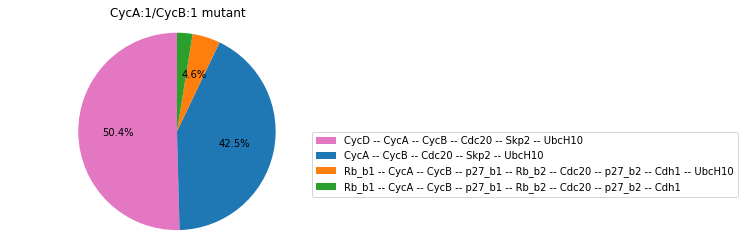

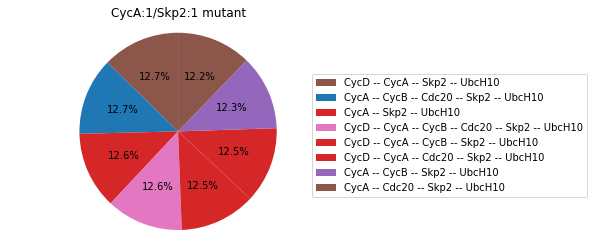

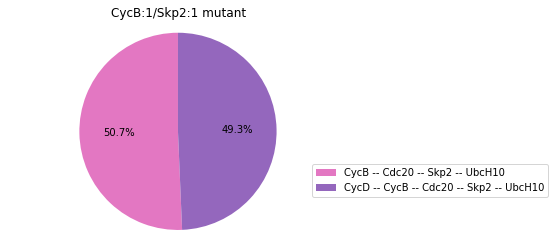

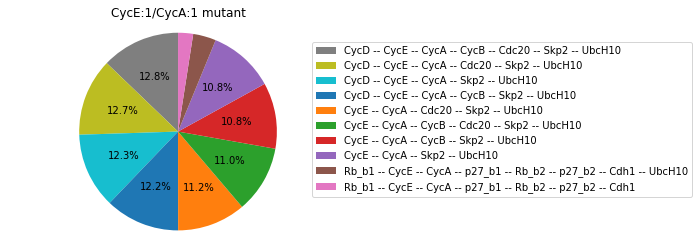

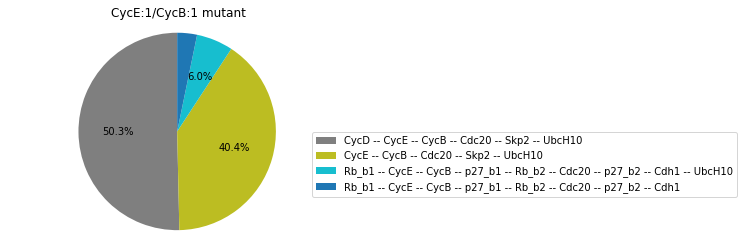

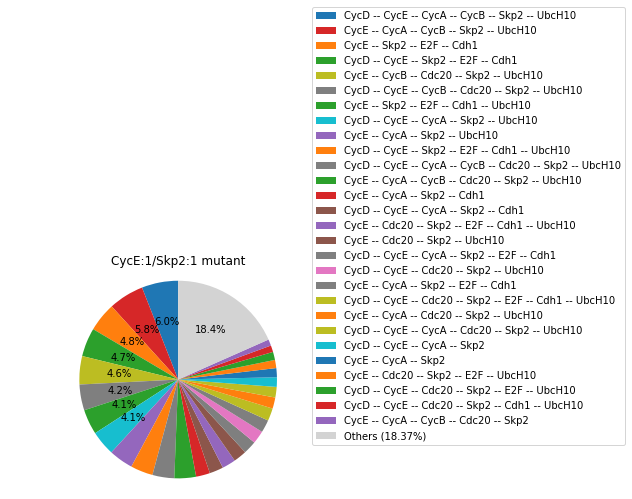

In [23]:
for mutant in sorted(candidates):
    mut_sim = wt_sim.copy()
    for (node, value) in mutant:
        mut_sim.mutate(node, "ON" if value else "OFF")
    mut_res = mut_sim.run()
    mut_res.plot_piechart(embed_labels=False, autopct=4)
    mutant_name = "/".join(["%s:%s"%m for m in mutant])
    plt.title("%s mutant" %mutant_name)
    

For all the mutations we observe that the number of possible states depends on which cyclin is mutated to be active. For example, when CycE is set to be active we are able to reach every state, starting from early G1 to early mitosis where all the cyclins are degradated by the APC complex (see last plot above).
In the cases of double cyclin mutants we observe a small percentage that corresponds to the cells being arrested in the S-phase.

### Verification of biological properties through model checking (nuSMV)

Finally, we analyse some biological properties mentioned in *Traynard et al.* paper using model checking in order to reproduce their results.

We focus on specific sequential events of the cell cycle such as the activation of the cyclins and the irreversibility of the S-phase.

In [24]:
lqm = ginsim.to_biolqm(lrg)

In [25]:
smv_cycle = """Cycle1 := (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1)| (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=0 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=0 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=1 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=0 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=0 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=0 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=0 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=0 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=0 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1) | (CycD=1 & Rb=1 & E2F=1 & CycE=1 & CycA=0 & CycB=1 & p27=1 & Cdc20=1 & Cdh1=1 & UbcH10=1 & Skp2=1);"""
smv = ginsim.to_nusmv(lrg)
smv.add_instruction(smv_cycle)

In [26]:
"""Define initial states"""
initial_G1 = S(CycE=0,CycA=0,CycB=0,Rb=1,p27=1,Cdh1=1,Cdc20=0,UbcH10=0,E2F=0)
initial_G2 = S(CycE=0,CycA=1,CycB=0,Rb=0,p27=0,Cdh1=0,Cdc20=0,UbcH10=0,E2F=0)

In [27]:
"""Sequential activation of Cyclins"""
Cyclin_activation = "!E[(CycE=0 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=0 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=0  & Cycle1)])])])])])]"

"""Complete removal of CycB is required to prevent spindle checkpoint"""
CycB_removal = "!E[(CycE=0 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=0 & CycB=0  & Cycle1) U ( CycE=1 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=1 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=0  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=0  & Cycle1) U ( CycE=0 & CycA=1 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=1 & CycB=1  & Cycle1) U ( CycE=0 & CycA=0 & CycB=1  & Cycle1 & E[( CycE=0 & CycA=0 & CycB=1  & Cycle1) U ( CycE=1 & CycA=0 & CycB=0  & Cycle1)])])])])])]"

"""Irreversibility of S-phase initiation / Correct order starting from G1""" 
Irreversible_S_correct = "!E[(CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=0 & CycA=0 & p27=1 & Cycle1 & E[( CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=1 & Cycle1 & E[( CycE=1 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=0 & Cycle1 & E[( CycE=1 & CycA=0 & p27=0 & Cycle1) U ( CycE=1 & CycA=1 & p27=0 & Cycle1 & E[( CycE=1 & CycA=1 & p27=0 & Cycle1) U ( CycE=0 & CycA=1 & p27=0 & Cycle1 & E[( CycE=1 & CycA=1 & p27=0 & Cycle1) U (CycE=0 & CycA=1 & p27=0 & Cycle1)])])])])])]"

""""Incorrect sequence starting from G1 (p27 inhibited without CycE)"""
Irreversible_S_incorrect = "!E[(CycE=0 & CycA=0 & p27=1  & Cycle1) U ( CycE=0 & CycA=0 & p27=0  & Cycle1 & E[( CycE=0 & CycA=0 & p27=0  & Cycle1) U ( CycE=1 & CycA=1 & p27=0  & Cycle1 & E[( CycE=1 & CycA=1 & p27=0  & Cycle1) U ( CycE=0 & CycA=1 & p27=0  & Cycle1)])])]"

"""Incorrect sequence starting from G1 (CycA activated before p27 inhibition)"""
Irreversible_S_incor2 = "!E[( CycE=0 & CycA=0 & p27=1 & Cycle1) U ( CycE=1 & CycA=0 & p27=1 & Cycle1 &E[(CycE=0 & CycA=0 & p27=1 & Cycle1) U (CycE=1 & CycA=1 & p27=1 & Cycle1)])]"

"""Degradation of B cyclins by the APC/C complex is required for mitosis to take place / Correct sequence starting from G2"""
CycB_degradation_G2 = "!E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 &E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=0 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])])])]"

"""Incorrect sequence from G2(inactivation of CycB without Cdc20)"""
CycB_without_Cdc20 = "!E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 &E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=1 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=1 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])])])]"

"""Incorrect sequence from G2 (inactivation of CycA without Cdc20)"""
CycA_without_Cdc20 = "!E[(CycA=1 & CycB=0 & Cdc20=0 & Cycle1) U (CycA=1 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=1 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=1 & Cdc20=0 & Cycle1 & E[(CycA=0 & CycB=1 & Cdc20=0 & Cycle1) U (CycA=0 & CycB=0 & Cdc20=0 & Cycle1)])])]"



In [28]:
specs = {
    "Sequential_cyclin_activation": If(initial_G1, (Cyclin_activation)),
    "CycB_removal": If(initial_G1, (CycB_removal)),
    "Irreversible_S_correct": If(initial_G1, (Irreversible_S_correct)),
    "Irreversible_S_incorrect": If(initial_G1, (Irreversible_S_incorrect)),
    "Irreversible_S_incor2": If(initial_G1, (Irreversible_S_incor2)),
    "No_CycB_for_mitosis": If(initial_G2, (CycB_degradation_G2)),
    "CycB_without_Cdc20": If(initial_G2, (CycB_without_Cdc20)),
    "CycA_without_Cdc20": If(initial_G2, (CycA_without_Cdc20))
}

In [29]:
smv.add_ctls(specs)

In [30]:
smv.verify()

{'Sequential_cyclin_activation': False,
 'CycB_removal': True,
 'Irreversible_S_correct': False,
 'Irreversible_S_incorrect': True,
 'Irreversible_S_incor2': True,
 'No_CycB_for_mitosis': False,
 'CycB_without_Cdc20': True,
 'CycA_without_Cdc20': True}

To verify that these sequences are true and also unique, we test for their inexistance. This way we make sure that there is no possible alternative sequence. This kind of analysis makes more sense when the actual sequence is unknown, such as in *Traynard et al.* paper. For that reason, properties such as the irreversibility of the S-phase and the complete degradation of CycB for mitosis were tested in more than one ways to verify these hypotheses. 

### Conclusion

Within this project, we successfully used the tools included in the colomoto notebook to analyse the logical model of the Mammalian cell cycle (from *Traynard et al.*) with the aim to produce a complete and reproducible study. 

Some further analysis on the model that can be achieved in order to get new insights are:
* to consider extending the model: 
    * by adding regulators of CycA to avoid having two stable states representing the quiescent state. One regulator we considered was Myc, but because it was applying the same kind of regulation as the other regulators already included in the model, we decided that adding that would only complicate the computations.
    * by adding G2 regulators, such as Aurora, PLK1 and Emi1. This needs a careful identification of the logical rules to  be added in the model.
    * by looking at existing models in public repositories (e.g, CellCollective) and include interesting bits of interactions.
* to refine and validate the model using highthroughput data.